In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

In [2]:
import sys
sys.path.append('scripts/')
from simulation_based_likelihood import *
from block_smc import *
from synthetic_data import *

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# Set font properties for ticks
plt.rcParams['xtick.labelsize'] = 24  # Font size of x-axis tick labels
plt.rcParams['ytick.labelsize'] = 24  # Font size of y-axis tick labels

# Set font properties for labels
plt.rcParams['axes.labelsize'] = 30  # Font size of axis labels

# Set font properties for title
plt.rcParams['axes.titlesize'] = 34  # Font size of title

# SimBa-CL vs SMC

We show how to compare SimBa-CL with SMC

The folder ``table'' contains the data we used

In [3]:
########################################
# Generate data
covariates_n = 2

M = 2
N = 100
covmean = 0
initial_infection_rate = 0.01
T = 100
epsilon_value = 0.001

W = tf.convert_to_tensor(np.load("data/table/W_numpy.npy"), dtype=tf.float32)
y = tf.convert_to_tensor(np.einsum("ijk->kij", np.load("data/table/Y_numpy.npy")), dtype=tf.float32)

W_tensor = tf.convert_to_tensor(W, dtype = tf.float32)

input_0      = tuple([W_tensor])
input_kernel = tuple([W_tensor])

model = compartmental_model(N, input_0, input_kernel, SIS_initial, SIS_transition)

beta_0      = tf.convert_to_tensor( [-np.log((1/initial_infection_rate)-1), +0], dtype = tf.float32 )
beta_lambda = tf.convert_to_tensor( [-1,           +2],      dtype = tf.float32 )  
beta_gamma  = tf.convert_to_tensor( [-1,           -1],      dtype = tf.float32 )  
epsilon     = tf.convert_to_tensor( [epsilon_value],                  dtype = tf.float32 )  

parameters_0 = tuple([beta_0])
parameters_kernel = beta_lambda, beta_gamma, epsilon

q_0      = tf.convert_to_tensor([0.0, 0.0], dtype = tf.float32)   
q_static = tf.convert_to_tensor([0.6, 0.4], dtype = tf.float32)

q_0_expanded      = tf.expand_dims(tf.expand_dims(q_0, axis = 0), axis = 0)
q_static_expanded = tf.expand_dims(tf.expand_dims(q_static, axis = 0), axis = 0)

q_dynamic = tf.concat((q_0_expanded*tf.ones((1, N, M)), q_static_expanded*tf.ones((T, N, M))), axis =0)

parameters_emission = tuple([q_static])

In [4]:
import time 

In [5]:
replicates = 10
parallel_simulations    = 512

In [6]:
########################################
########################################
# likelihood experiment

loglikelihood_BBPF_DGP    = np.zeros((replicates))
loglikelihood_BAPF_DGP    = np.zeros((replicates))

cost_BBPF_DGP    = np.zeros((replicates))
cost_BAPF_DGP    = np.zeros((replicates))

# DGP
seed_simulation_1 = tfp.random.split_seed( 123, n = replicates, salt = 'test_1')
seed_simulation_2 = tfp.random.split_seed( 123, n = replicates, salt = 'test_2')

for k in range(replicates):

    simulation_likelihood_model = simulation_likelihood(parallel_simulations, N, input_0, input_kernel, SIS_initial, SIS_transition, SIS_emission)

    startTime = time.time()
    log_likelihood_BBPF = run_BBPF(simulation_likelihood_model, parameters_0, parameters_kernel, parameters_emission, y, seed_simulation_1[k][0])
    executionTime = (time.time() - startTime)    

    loglikelihood_BBPF_DGP[k] = log_likelihood_BBPF.numpy()
    cost_BBPF_DGP[k]          = executionTime

    startTime = time.time()
    log_likelihood_BAPF = run_BAPF(simulation_likelihood_model, parameters_0, parameters_kernel, parameters_emission, y, seed_simulation_2[k][0])
    executionTime = (time.time() - startTime)


    loglikelihood_BAPF_DGP[k] = log_likelihood_BAPF.numpy()
    cost_BAPF_DGP[k]          = executionTime

In [7]:
loglikelihood_approx_DGP    = np.zeros((replicates))
cost_approx_DGP    = np.zeros((replicates))

seed_simulation_3 = tfp.random.split_seed( 123, n = replicates, salt = 'test_3')

for k in range(replicates):

    simulation_likelihood_model = simulation_likelihood(parallel_simulations, N, input_0, input_kernel, SIS_initial, SIS_transition, SIS_emission)

    startTime = time.time()
    log_likelihood_approx = run_simulation_likelihood_approx(simulation_likelihood_model, parameters_0, parameters_kernel, parameters_emission, y, seed_simulation_3[k][0])
    executionTime = (time.time() - startTime)
    log_likelihood_approx = tf.reduce_sum(tf.math.log(tf.reduce_mean(tf.math.exp(log_likelihood_approx - tf.reduce_max(log_likelihood_approx, axis = 0, keepdims=True)), axis = 0)) + tf.reduce_max(log_likelihood_approx, axis = 0))

    loglikelihood_approx_DGP[k] = log_likelihood_approx.numpy()
    cost_approx_DGP[k]          = executionTime



We can plot the costs

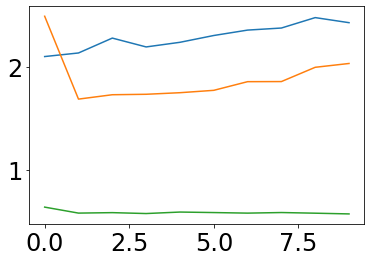

In [14]:
plt.plot(cost_BAPF_DGP)
plt.plot(cost_BBPF_DGP)
plt.plot(cost_approx_DGP)

We can also plot the marginal likelihoods

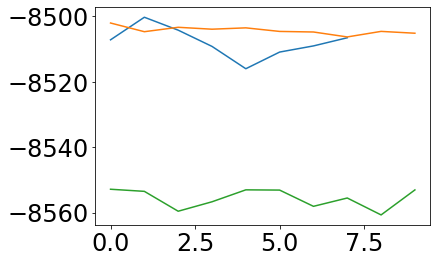

In [15]:
plt.plot(loglikelihood_BBPF_DGP)
plt.plot(loglikelihood_BAPF_DGP)
plt.plot(loglikelihood_approx_DGP)

The above can be iterated for different particles numbers and algorithms. We report below the tables from the main paper.

## Paper tables

In [16]:
from tabulate import tabulate
import statistics

In [17]:
files_in_dir = os.listdir("data/table/N100/block_smc")

files_block_smc_cost = []
files_block_smc_loglike = []

for file in files_in_dir:

    if file[3:7]=="cost" or  file[4:8]=="cost":

        files_block_smc_cost.append(file)

    else:

        files_block_smc_loglike.append(file)           

files_block_smc_cost_BBPF =[]
files_block_smc_loglike_BBPF =[]

files_block_smc_cost_BAPF = []
files_block_smc_loglike_BAPF = []

for file in files_block_smc_cost:

    if file[-12:-8]=="BAPF":

        files_block_smc_cost_BAPF.append(file)

    else:
        files_block_smc_cost_BBPF.append(file)


for file in files_block_smc_loglike:

    if file[-12:-8]=="BAPF":

        files_block_smc_loglike_BAPF.append(file)

    else:
        files_block_smc_loglike_BBPF.append(file)

block_smc_cost_BBPF = { file[:4] if (file[:4]).isdigit() else file[:3]: np.mean(np.load("data/table/N100/block_smc/"+file)) for file in files_block_smc_cost_BBPF}
block_smc_cost_BAPF = { file[:4] if (file[:4]).isdigit() else file[:3]: np.mean(np.load("data/table/N100/block_smc/"+file)) for file in files_block_smc_cost_BAPF}

block_smc_loglike_BBPF = { file[:4] if (file[:4]).isdigit() else file[:3]: (np.load("data/table/N100/block_smc/"+file)) for file in files_block_smc_loglike_BBPF}
block_smc_loglike_BAPF = { file[:4] if (file[:4]).isdigit() else file[:3]: (np.load("data/table/N100/block_smc/"+file)) for file in files_block_smc_loglike_BAPF}

files_in_dir = os.listdir("data/table/N100/simulation_likelihood")

files_sim_like_cost = []
files_sim_like_loglike = []

for file in files_in_dir:

    if file[3:7]=="cost" or  file[4:8]=="cost" or file[-12:-8]=="cost":

        files_sim_like_cost.append(file)

    else:

        files_sim_like_loglike.append(file)      


files_sim_like_cost_exact =[]
files_sim_like_cost_approx =[]
files_sim_like_cost_coupled =[]

files_sim_like_loglike_exact = []
files_sim_like_loglike_approx = []
files_sim_like_loglike_coupled = []

for file in files_sim_like_cost:

    if file[9:15]=="approx" or  file[8:14]=="approx":

        files_sim_like_cost_approx.append(file)

    elif file[0:7]=="coupled":
        files_sim_like_cost_coupled.append(file)

    else:
        files_sim_like_cost_exact.append(file)


for file in files_sim_like_loglike:
    
    if file[-14:-8]=="approx":

        files_sim_like_loglike_approx.append(file)

    elif file[0:7]=="coupled":
        files_sim_like_loglike_coupled.append(file)

    else:
        files_sim_like_loglike_exact.append(file)


sim_like_cost_exact = { file[:4] if (file[:4]).isdigit() else file[:3]: np.mean(np.load("data/table/N100/simulation_likelihood/"+file)) for file in files_sim_like_cost_exact}
sim_like_cost_approx = { file[:4] if (file[:4]).isdigit() else file[:3]: np.mean(np.load("data/table/N100/simulation_likelihood/"+file)) for file in files_sim_like_cost_approx}
sim_like_cost_coupled = { file[8:12] if (file[8:12]).isdigit() else file[8:13]: np.mean(np.load("data/table/N100/simulation_likelihood/"+file)) for file in files_sim_like_cost_coupled}

sim_like_loglike_exact = { file[:4] if (file[:4]).isdigit() else file[:3]: (np.load("data/table/N100/simulation_likelihood/"+file)) for file in files_sim_like_loglike_exact}
sim_like_loglike_approx = { file[:4] if (file[:4]).isdigit() else file[:3]: (np.load("data/table/N100/simulation_likelihood/"+file)) for file in files_sim_like_loglike_approx}
sim_like_loglike_coupled = { file[8:12] if (file[8:12]).isdigit() else file[8:11]: (np.load("data/table/N100/simulation_likelihood/"+file)) for file in files_sim_like_loglike_coupled}


CostTable_SIS_DGP_numpy    = np.load("data/table/N100/smc/CostTable_SIS_DGP_numpy.npy")
LikelihoodTable_SIS_DGP_numpy    = np.load("data/table/N100/smc/LikelihoodTable_SIS_DGP_numpy.npy")

LikelihoodTable_SIS_DGP_numpy_mean    = np.nanmean(LikelihoodTable_SIS_DGP_numpy, axis =2)
LikelihoodTable_SIS_DGP_numpy_std    = np.nanstd(LikelihoodTable_SIS_DGP_numpy, axis =2)

CostTable_SIS_DGP_numpy_mean    = np.mean(CostTable_SIS_DGP_numpy, axis =2)
CostTable_SIS_DGP_numpy_std    = np.std(CostTable_SIS_DGP_numpy, axis =2)

LikelihoodTable_SIS_DGP_numpy_mean = LikelihoodTable_SIS_DGP_numpy_mean[:, np.array([0, 2, 3, 4, 5])]
LikelihoodTable_SIS_DGP_numpy_std  = LikelihoodTable_SIS_DGP_numpy_std[ :, np.array([0, 2, 3, 4, 5])]
CostTable_SIS_DGP_numpy_mean = CostTable_SIS_DGP_numpy_mean[:, np.array([0, 2, 3, 4, 5])]
CostTable_SIS_DGP_numpy_std  = CostTable_SIS_DGP_numpy_std[ :, np.array([0, 2, 3, 4, 5])]

Nx_list    = [512, 1024, 2048]
h_list     = [1, 2, 5, 10]

smc_cost = np.mean(CostTable_SIS_DGP_numpy_mean, axis = 0)

# CostTable_SIS_DGP_simulation_approx_numpy_mean = np.mean(CostTable_SIS_DGP_simulation_approx_numpy_mean)
# CostTable_SIS_DGP_simulation_numpy_mean = np.mean(CostTable_SIS_DGP_simulation_numpy_mean)
# CostTable_SIS_DGP_simulation_coupled_numpy_mean = np.mean(CostTable_SIS_DGP_simulation_coupled_numpy_mean)

table = []

table_row = ["P", "APF: "+str(round(smc_cost[0], 2))+"s"]
i =0
for h in h_list:
    i = i +1
    table_row.append("h="+ str(h)+": "+str(round(smc_cost[i], 2))+"s")

table_row.append("Block BPF: "+str(round(statistics.mean(block_smc_cost_BBPF.values()), 2))+"s")
table_row.append("Block APF: "+str(round(statistics.mean(block_smc_cost_BAPF.values()), 2))+"s")

table_row.append("With feedback: "+str(round(statistics.mean(sim_like_cost_exact.values()), 2))+"s")
table_row.append("Without feedback: "+str(round(statistics.mean(sim_like_cost_approx.values()), 2))+"s")
table_row.append("Coupled: "+str(round(statistics.mean(sim_like_cost_coupled.values()), 2))+"s")

# table_row.append("Feedback: "+str(np.round(CostTable_SIS_DGP_simulation_numpy_mean, 2))+"s")
# table_row.append("Without feedback: "+str(np.round(CostTable_SIS_DGP_simulation_approx_numpy_mean, 2))+"s")
# table_row.append("Coupled: "+str(np.round(CostTable_SIS_DGP_simulation_coupled_numpy_mean, 2))+"s")

table.append(table_row)

for j in range(len(Nx_list)):

    table_row = [str(Nx_list[j])]

    for i in range(LikelihoodTable_SIS_DGP_numpy_std.shape[1]):

        # table_row.append(str(round(LikelihoodTable_SIS_DGP_numpy_std[j,i], 2)))

        table_row.append(str(round(LikelihoodTable_SIS_DGP_numpy_mean[j,i], 2))  + " (" + str(round(LikelihoodTable_SIS_DGP_numpy_std[j,i], 2)) + ")")


    block_smc_loglike_BBPF_array =  np.where(np.isfinite(block_smc_loglike_BBPF[table_row[0]]), block_smc_loglike_BBPF[table_row[0]], np.nan)
    block_smc_loglike_BAPF_array =  np.where(np.isfinite(block_smc_loglike_BAPF[table_row[0]]), block_smc_loglike_BAPF[table_row[0]], np.nan)

    table_row.append(str(round(np.nanmean(block_smc_loglike_BBPF_array), 2))  + " (" + str(round(np.nanstd(block_smc_loglike_BBPF_array), 2)) + ")")
    table_row.append(str(round(np.nanmean(block_smc_loglike_BAPF_array), 2))  + " (" + str(round(np.nanstd(block_smc_loglike_BAPF_array), 2)) + ")")


    sim_like_loglike_exact_array = sim_like_loglike_exact[table_row[0]] #np.where(np.isfinite(sim_like_loglike_exact[table_row[0]]), sim_like_loglike_exact[table_row[0]], np.nan)
    sim_like_loglike_approx_array = sim_like_loglike_approx[table_row[0]] #np.where(np.isfinite(sim_like_loglike_approx[table_row[0]]), sim_like_loglike_approx[table_row[0]], np.nan)
    sim_like_loglike_coupled_array = sim_like_loglike_coupled[table_row[0]] #np.where(np.isfinite(sim_like_loglike_coupled[table_row[0]]), sim_like_loglike_coupled[table_row[0]], np.nan)

    table_row.append(str(round(np.nanmean(sim_like_loglike_exact_array), 2))  + " (" + str(round(np.nanstd(sim_like_loglike_exact_array), 2)) + ")")
    table_row.append(str(round(np.nanmean(sim_like_loglike_approx_array), 2))  + " (" + str(round(np.nanstd(sim_like_loglike_approx_array), 2)) + ")")
    table_row.append(str(round(np.nanmean(sim_like_loglike_coupled_array), 2))  + " (" + str(round(np.nanstd(sim_like_loglike_coupled_array), 2)) + ")")



#     # table_row.append(str(round(LikelihoodTable_SIS_DGP_simulation_numpy_std[j], 2)))
#     # table_row.append(str(round(LikelihoodTable_SIS_DGP_simulation_approx_numpy_std[j], 2)))
#     # table_row.append(str(round(LikelihoodTable_SIS_DGP_simulation_coupled_numpy_std[j], 2)))

#     table_row.append(str(round(LikelihoodTable_SIS_DGP_simulation_numpy_mean[j], 2))+ "+/-" + str(round(LikelihoodTable_SIS_DGP_simulation_numpy_std[j], 2)))
#     table_row.append(str(round(LikelihoodTable_SIS_DGP_simulation_approx_numpy_mean[j], 2))+ "+/-" + str(round(LikelihoodTable_SIS_DGP_simulation_approx_numpy_std[j], 2)))
#     table_row.append(str(round(LikelihoodTable_SIS_DGP_simulation_coupled_numpy_mean[j], 2))+ "+/-" + str(round(LikelihoodTable_SIS_DGP_simulation_coupled_numpy_std[j], 2)))

    table.append(table_row)

In [18]:
transposed_table = list(zip(*table))
print(tabulate(transposed_table, headers='firstrow', tablefmt='fancy_grid'))

╒═════════════════════════╤═════════════════╤═════════════════╤═════════════════╕
│ P                       │ 512             │ 1024            │ 2048            │
╞═════════════════════════╪═════════════════╪═════════════════╪═════════════════╡
│ APF: 0.85s              │ -8551.4 (6.97)  │ -8541.01 (7.78) │ -8533.75 (6.3)  │
├─────────────────────────┼─────────────────┼─────────────────┼─────────────────┤
│ h=1: 1.52s              │ -8507.15 (1.07) │ -8507.07 (0.78) │ -8506.97 (0.58) │
├─────────────────────────┼─────────────────┼─────────────────┼─────────────────┤
│ h=2: 1.91s              │ -8506.63 (0.42) │ -8506.65 (0.27) │ -8506.64 (0.22) │
├─────────────────────────┼─────────────────┼─────────────────┼─────────────────┤
│ h=5: 3.04s              │ -8506.58 (0.27) │ -8506.68 (0.54) │ -8506.61 (0.16) │
├─────────────────────────┼─────────────────┼─────────────────┼─────────────────┤
│ h=10: 4.86s             │ -8506.62 (0.29) │ -8506.62 (0.21) │ -8506.63 (0.15) │
├───────────────

In [19]:
files_in_dir = os.listdir("data/table/N1000/block_smc")

files_block_smc_cost = []
files_block_smc_loglike = []

for file in files_in_dir:

    if file[3:7]=="cost" or  file[4:8]=="cost":

        files_block_smc_cost.append(file)

    else:

        files_block_smc_loglike.append(file)           

files_block_smc_cost_BBPF =[]
files_block_smc_loglike_BBPF =[]

files_block_smc_cost_BAPF = []
files_block_smc_loglike_BAPF = []

for file in files_block_smc_cost:

    if file[-12:-8]=="BAPF":

        files_block_smc_cost_BAPF.append(file)

    else:
        files_block_smc_cost_BBPF.append(file)


for file in files_block_smc_loglike:

    if file[-12:-8]=="BAPF":

        files_block_smc_loglike_BAPF.append(file)

    else:
        files_block_smc_loglike_BBPF.append(file)

block_smc_cost_BBPF = { file[:4] if (file[:4]).isdigit() else file[:3]: np.mean(np.load("data/table/N1000/block_smc/"+file)) for file in files_block_smc_cost_BBPF}
# block_smc_cost_BBPF["2048"] = np.nan 
block_smc_cost_BAPF = { file[:4] if (file[:4]).isdigit() else file[:3]: np.mean(np.load("data/table/N1000/block_smc/"+file)) for file in files_block_smc_cost_BAPF}
# block_smc_cost_BAPF["2048"] = np.nan 

block_smc_loglike_BBPF = { file[:4] if (file[:4]).isdigit() else file[:3]: (np.load("data/table/N1000/block_smc/"+file)) for file in files_block_smc_loglike_BBPF}
block_smc_loglike_BBPF["2048"] = np.nan*np.zeros(100) 
block_smc_loglike_BAPF = { file[:4] if (file[:4]).isdigit() else file[:3]: (np.load("data/table/N1000/block_smc/"+file)) for file in files_block_smc_loglike_BAPF}
block_smc_loglike_BAPF["2048"] = np.nan*np.zeros(100) 


files_in_dir = os.listdir("data/table/N1000/simulation_likelihood")

files_sim_like_cost = []
files_sim_like_loglike = []

for file in files_in_dir:

    if file[3:7]=="cost" or  file[4:8]=="cost" or file[-17:-13]=="cost":

        files_sim_like_cost.append(file)

    else:

        files_sim_like_loglike.append(file)      


files_sim_like_cost_approx =[]
files_sim_like_cost_coupled =[]

files_sim_like_loglike_approx = []
files_sim_like_loglike_coupled = []

for file in files_sim_like_cost:

    if file[9:15]=="approx" or  file[8:14]=="approx":

        files_sim_like_cost_approx.append(file)

    elif file[0:7]=="coupled":
        files_sim_like_cost_coupled.append(file)



for file in files_sim_like_loglike:
    
    if file[-19:-13]=="approx":

        files_sim_like_loglike_approx.append(file)

    elif file[0:7]=="coupled":
        files_sim_like_loglike_coupled.append(file)



sim_like_cost_approx = { file[:4] if (file[:4]).isdigit() else file[:3]: np.mean(np.load("data/table/N1000/simulation_likelihood/"+file)) for file in files_sim_like_cost_approx}
sim_like_cost_coupled = { file[8:12] if (file[8:12]).isdigit() else file[8:13]: np.mean(np.load("data/table/N1000/simulation_likelihood/"+file)) for file in files_sim_like_cost_coupled}

sim_like_loglike_approx = { file[:4] if (file[:4]).isdigit() else file[:3]: (np.load("data/table/N1000/simulation_likelihood/"+file)) for file in files_sim_like_loglike_approx}
sim_like_loglike_coupled = { file[8:12] if (file[8:12]).isdigit() else file[8:11]: (np.load("data/table/N1000/simulation_likelihood/"+file)) for file in files_sim_like_loglike_coupled}

CostTable_SIS_DGP_numpy    = np.load("data/table/N1000/smc/CostTable_SIS_DGP_1000_numpy.npy")
LikelihoodTable_SIS_DGP_numpy    = np.load("data/table/N1000/smc/LikelihoodTable_SIS_DGP_1000_numpy.npy")

LikelihoodTable_SIS_DGP_numpy_mean    = np.nanmean(LikelihoodTable_SIS_DGP_numpy, axis =2)
LikelihoodTable_SIS_DGP_numpy_std    = np.nanstd(LikelihoodTable_SIS_DGP_numpy, axis =2)

CostTable_SIS_DGP_numpy_mean    = np.mean(CostTable_SIS_DGP_numpy, axis =2)
CostTable_SIS_DGP_numpy_std    = np.std(CostTable_SIS_DGP_numpy, axis =2)

LikelihoodTable_SIS_DGP_numpy_mean = LikelihoodTable_SIS_DGP_numpy_mean
LikelihoodTable_SIS_DGP_numpy_std = LikelihoodTable_SIS_DGP_numpy_std
CostTable_SIS_DGP_numpy_mean = CostTable_SIS_DGP_numpy_mean
CostTable_SIS_DGP_numpy_std = CostTable_SIS_DGP_numpy_std

In [20]:
Nx_list    = [512, 1024, 2048]
h_list     = [1, 2, 5, 10]

smc_cost = np.mean(CostTable_SIS_DGP_numpy_mean, axis = 0)

# CostTable_SIS_DGP_simulation_approx_numpy_mean = np.mean(CostTable_SIS_DGP_simulation_approx_numpy_mean)
# CostTable_SIS_DGP_simulation_numpy_mean = np.mean(CostTable_SIS_DGP_simulation_numpy_mean)
# CostTable_SIS_DGP_simulation_coupled_numpy_mean = np.mean(CostTable_SIS_DGP_simulation_coupled_numpy_mean)

table = []

table_row = ["P", "APF: "+str(round(smc_cost[0], 2))+"s"]
i =0
for h in h_list:
    i = i +1
    table_row.append("h="+ str(h)+": "+str(round(smc_cost[i], 2))+"s")

table_row.append("Block BPF: "+str(round(statistics.mean(block_smc_cost_BBPF.values()), 2))+"s")
table_row.append("Block APF: "+str(round(statistics.mean(block_smc_cost_BAPF.values()), 2))+"s")

# table_row.append("With feedback: "+str(round(statistics.mean(sim_like_cost_exact.values()), 2))+"s")
table_row.append("Without feedback: "+str(round(statistics.mean(sim_like_cost_approx.values()), 2))+"s")
table_row.append("Coupled: "+str(round(statistics.mean(sim_like_cost_coupled.values()), 2))+"s")

# table_row.append("Feedback: "+str(np.round(CostTable_SIS_DGP_simulation_numpy_mean, 2))+"s")
# table_row.append("Without feedback: "+str(np.round(CostTable_SIS_DGP_simulation_approx_numpy_mean, 2))+"s")
# table_row.append("Coupled: "+str(np.round(CostTable_SIS_DGP_simulation_coupled_numpy_mean, 2))+"s")

table.append(table_row)

for j in range(len(Nx_list)):

    table_row = [str(Nx_list[j])]

    for i in range(LikelihoodTable_SIS_DGP_numpy_std.shape[1]):

        # table_row.append(str(round(LikelihoodTable_SIS_DGP_numpy_std[j,i], 2)))

        table_row.append(str(round(LikelihoodTable_SIS_DGP_numpy_mean[j,i], 2))  + " (" + str(round(LikelihoodTable_SIS_DGP_numpy_std[j,i], 2)) + ")")


    block_smc_loglike_BBPF_array =  np.where(np.isfinite(block_smc_loglike_BBPF[table_row[0]]), block_smc_loglike_BBPF[table_row[0]], np.nan)
    block_smc_loglike_BAPF_array =  np.where(np.isfinite(block_smc_loglike_BAPF[table_row[0]]), block_smc_loglike_BAPF[table_row[0]], np.nan)

    table_row.append(str(round(np.nanmean(block_smc_loglike_BBPF_array), 2))  + " (" + str(round(np.nanstd(block_smc_loglike_BBPF_array), 2)) + ")")
    table_row.append(str(round(np.nanmean(block_smc_loglike_BAPF_array), 2))  + " (" + str(round(np.nanstd(block_smc_loglike_BAPF_array), 2)) + ")")


    # sim_like_loglike_exact_array = sim_like_loglike_exact[table_row[0]] #np.where(np.isfinite(sim_like_loglike_exact[table_row[0]]), sim_like_loglike_exact[table_row[0]], np.nan)
    sim_like_loglike_approx_array = sim_like_loglike_approx[table_row[0]] #np.where(np.isfinite(sim_like_loglike_approx[table_row[0]]), sim_like_loglike_approx[table_row[0]], np.nan)
    sim_like_loglike_coupled_array = sim_like_loglike_coupled[table_row[0]] #np.where(np.isfinite(sim_like_loglike_coupled[table_row[0]]), sim_like_loglike_coupled[table_row[0]], np.nan)

    # table_row.append(str(round(np.nanmean(sim_like_loglike_exact_array), 2))  + " (" + str(round(np.nanstd(sim_like_loglike_exact_array), 2)) + ")")
    table_row.append(str(round(np.nanmean(sim_like_loglike_approx_array), 2))  + " (" + str(round(np.nanstd(sim_like_loglike_approx_array), 2)) + ")")
    table_row.append(str(round(np.nanmean(sim_like_loglike_coupled_array), 2))  + " (" + str(round(np.nanstd(sim_like_loglike_coupled_array), 2)) + ")")



#     # table_row.append(str(round(LikelihoodTable_SIS_DGP_simulation_numpy_std[j], 2)))
#     # table_row.append(str(round(LikelihoodTable_SIS_DGP_simulation_approx_numpy_std[j], 2)))
#     # table_row.append(str(round(LikelihoodTable_SIS_DGP_simulation_coupled_numpy_std[j], 2)))

#     table_row.append(str(round(LikelihoodTable_SIS_DGP_simulation_numpy_mean[j], 2))+ "+/-" + str(round(LikelihoodTable_SIS_DGP_simulation_numpy_std[j], 2)))
#     table_row.append(str(round(LikelihoodTable_SIS_DGP_simulation_approx_numpy_mean[j], 2))+ "+/-" + str(round(LikelihoodTable_SIS_DGP_simulation_approx_numpy_std[j], 2)))
#     table_row.append(str(round(LikelihoodTable_SIS_DGP_simulation_coupled_numpy_mean[j], 2))+ "+/-" + str(round(LikelihoodTable_SIS_DGP_simulation_coupled_numpy_std[j], 2)))

    table.append(table_row)

C:\Users\loren\AppData\Local\Temp\ipykernel_8380\2111447714.py:45: RuntimeWarning: Mean of empty slice
  table_row.append(str(round(np.nanmean(block_smc_loglike_BBPF_array), 2))  + " (" + str(round(np.nanstd(block_smc_loglike_BBPF_array), 2)) + ")")
c:\Users\loren\anaconda3\envs\TensorFlow\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\loren\AppData\Local\Temp\ipykernel_8380\2111447714.py:46: RuntimeWarning: Mean of empty slice
  table_row.append(str(round(np.nanmean(block_smc_loglike_BAPF_array), 2))  + " (" + str(round(np.nanstd(block_smc_loglike_BAPF_array), 2)) + ")")


In [21]:
transposed_table = list(zip(*table))
print(tabulate(transposed_table, headers='firstrow', tablefmt='fancy_grid'))

╒═════════════════════════╤═══════════════════╤═══════════════════╤═══════════════════╕
│ P                       │ 512               │ 1024              │ 2048              │
╞═════════════════════════╪═══════════════════╪═══════════════════╪═══════════════════╡
│ APF: 1.05s              │ -81103.37 (46.04) │ -81046.57 (49.65) │ -80976.34 (36.08) │
├─────────────────────────┼───────────────────┼───────────────────┼───────────────────┤
│ h=1: 2.23s              │ -79629.57 (9.46)  │ -79615.95 (7.87)  │ -79603.15 (8.34)  │
├─────────────────────────┼───────────────────┼───────────────────┼───────────────────┤
│ h=2: 2.62s              │ -79555.02 (2.53)  │ -79554.2 (2.17)   │ -79553.98 (1.63)  │
├─────────────────────────┼───────────────────┼───────────────────┼───────────────────┤
│ h=5: 3.78s              │ -79551.92 (1.79)  │ -79552.24 (1.6)   │ -79552.81 (1.57)  │
├─────────────────────────┼───────────────────┼───────────────────┼───────────────────┤
│ h=10: 5.61s             │ -795

In [23]:
files_in_dir = os.listdir("data/table/SEIR/block_smc")

files_block_smc_cost = []
files_block_smc_loglike = []

for file in files_in_dir:

    if file[3:7]=="cost" or  file[4:8]=="cost":

        files_block_smc_cost.append(file)

    else:

        files_block_smc_loglike.append(file)           

files_block_smc_cost_BBPF =[]
files_block_smc_loglike_BBPF =[]

files_block_smc_cost_BAPF = []
files_block_smc_loglike_BAPF = []

for file in files_block_smc_cost:

    if file[-13:-9]=="BAPF":

        files_block_smc_cost_BAPF.append(file)

    else:
        files_block_smc_cost_BBPF.append(file)


for file in files_block_smc_loglike:

    if file[-13:-9]=="BAPF":

        files_block_smc_loglike_BAPF.append(file)

    else:
        files_block_smc_loglike_BBPF.append(file)

block_smc_cost_BBPF = { file[:4] if (file[:4]).isdigit() else file[:3]: np.mean(np.load("data/table/SEIR/block_smc/"+file)) for file in files_block_smc_cost_BBPF}
block_smc_cost_BAPF = { file[:4] if (file[:4]).isdigit() else file[:3]: np.mean(np.load("data/table/SEIR/block_smc/"+file)) for file in files_block_smc_cost_BAPF}

block_smc_loglike_BBPF = { file[:4] if (file[:4]).isdigit() else file[:3]: (np.load("data/table/SEIR/block_smc/"+file)) for file in files_block_smc_loglike_BBPF}
block_smc_loglike_BAPF = { file[:4] if (file[:4]).isdigit() else file[:3]: (np.load("data/table/SEIR/block_smc/"+file)) for file in files_block_smc_loglike_BAPF}


files_in_dir = os.listdir("data/table/SEIR/simulation_likelihood")

files_sim_like_cost = []
files_sim_like_loglike = []

for file in files_in_dir:

    if file[3:7]=="cost" or  file[4:8]=="cost" or file[-12:-8]=="cost":

        files_sim_like_cost.append(file)

    else:

        files_sim_like_loglike.append(file)      



sim_like_cost_approx = { file[:4] if (file[:4]).isdigit() else file[:3]: np.mean(np.load("data/table/SEIR/simulation_likelihood/"+file)) for file in files_sim_like_cost}

sim_like_loglike_approx = { file[:4] if (file[:4]).isdigit() else file[:3]: (np.load("data/table/SEIR/simulation_likelihood/"+file)) for file in files_sim_like_loglike}

CostTable_SIS_DGP_numpy    = np.load("data/table/SEIR/smc/SEIR_CostTable_SIS_DGP_numpy.npy")
LikelihoodTable_SIS_DGP_numpy    = np.load("data/table/SEIR/smc/SEIR_LikelihoodTable_SIS_DGP_numpy.npy")

LikelihoodTable_SIS_DGP_numpy_mean    = np.nanmean(LikelihoodTable_SIS_DGP_numpy, axis =2)
LikelihoodTable_SIS_DGP_numpy_std    = np.nanstd(LikelihoodTable_SIS_DGP_numpy, axis =2)

CostTable_SIS_DGP_numpy_mean    = np.mean(CostTable_SIS_DGP_numpy, axis =2)
CostTable_SIS_DGP_numpy_std    = np.std(CostTable_SIS_DGP_numpy, axis =2)

LikelihoodTable_SIS_DGP_numpy_mean = LikelihoodTable_SIS_DGP_numpy_mean
LikelihoodTable_SIS_DGP_numpy_std = LikelihoodTable_SIS_DGP_numpy_std
CostTable_SIS_DGP_numpy_mean = CostTable_SIS_DGP_numpy_mean
CostTable_SIS_DGP_numpy_std = CostTable_SIS_DGP_numpy_std

C:\Users\loren\AppData\Local\Temp\ipykernel_8380\3681034673.py:72: RuntimeWarning: Mean of empty slice
  LikelihoodTable_SIS_DGP_numpy_mean    = np.nanmean(LikelihoodTable_SIS_DGP_numpy, axis =2)


In [24]:
Nx_list    = [512, 1024, 2048]
h_list     = [5, 10, 20, 50]

smc_cost = np.mean(CostTable_SIS_DGP_numpy_mean, axis = 0)

# CostTable_SIS_DGP_simulation_approx_numpy_mean = np.mean(CostTable_SIS_DGP_simulation_approx_numpy_mean)
# CostTable_SIS_DGP_simulation_numpy_mean = np.mean(CostTable_SIS_DGP_simulation_numpy_mean)
# CostTable_SIS_DGP_simulation_coupled_numpy_mean = np.mean(CostTable_SIS_DGP_simulation_coupled_numpy_mean)

table = []

table_row = ["P", "APF: "+str(round(smc_cost[0], 2))+"s"]
i =0
for h in h_list:
    i = i +1
    table_row.append("h="+ str(h)+": "+str(round(smc_cost[i], 2))+"s")

table_row.append("Block BPF: "+str(round(statistics.mean(block_smc_cost_BBPF.values()), 2))+"s")
table_row.append("Block APF: "+str(round(statistics.mean(block_smc_cost_BAPF.values()), 2))+"s")

# table_row.append("With feedback: "+str(round(statistics.mean(sim_like_cost_exact.values()), 2))+"s")
table_row.append("Without feedback: "+str(round(statistics.mean(sim_like_cost_approx.values()), 2))+"s")
# table_row.append("Coupled: "+str(round(statistics.mean(sim_like_cost_coupled.values()), 2))+"s")

# table_row.append("Feedback: "+str(np.round(CostTable_SIS_DGP_simulation_numpy_mean, 2))+"s")
# table_row.append("Without feedback: "+str(np.round(CostTable_SIS_DGP_simulation_approx_numpy_mean, 2))+"s")
# table_row.append("Coupled: "+str(np.round(CostTable_SIS_DGP_simulation_coupled_numpy_mean, 2))+"s")

table.append(table_row)

for j in range(len(Nx_list)):

    table_row = [str(Nx_list[j])]

    for i in range(LikelihoodTable_SIS_DGP_numpy_std.shape[1]):

        # table_row.append(str(round(LikelihoodTable_SIS_DGP_numpy_std[j,i], 2)))

        table_row.append(str(round(LikelihoodTable_SIS_DGP_numpy_mean[j,i], 2))  + "(" + str(round(LikelihoodTable_SIS_DGP_numpy_std[j,i], 2))+")")


    block_smc_loglike_BBPF_array =  np.where(np.isfinite(block_smc_loglike_BBPF[table_row[0]]), block_smc_loglike_BBPF[table_row[0]], np.nan)
    block_smc_loglike_BAPF_array =  np.where(np.isfinite(block_smc_loglike_BAPF[table_row[0]]), block_smc_loglike_BAPF[table_row[0]], np.nan)

    table_row.append(str(round(np.nanmean(block_smc_loglike_BBPF_array), 2))  + "(" + str(round(np.nanstd(block_smc_loglike_BBPF_array), 2))+")")
    table_row.append(str(round(np.nanmean(block_smc_loglike_BAPF_array), 2))  + "(" + str(round(np.nanstd(block_smc_loglike_BAPF_array), 2))+")")


    # sim_like_loglike_exact_array = sim_like_loglike_exact[table_row[0]] #np.where(np.isfinite(sim_like_loglike_exact[table_row[0]]), sim_like_loglike_exact[table_row[0]], np.nan)
    sim_like_loglike_approx_array = sim_like_loglike_approx[table_row[0]] #np.where(np.isfinite(sim_like_loglike_approx[table_row[0]]), sim_like_loglike_approx[table_row[0]], np.nan)
    # sim_like_loglike_coupled_array = sim_like_loglike_coupled[table_row[0]] #np.where(np.isfinite(sim_like_loglike_coupled[table_row[0]]), sim_like_loglike_coupled[table_row[0]], np.nan)

    # table_row.append(str(round(np.nanmean(sim_like_loglike_exact_array), 2))  + "(" + str(round(np.nanstd(sim_like_loglike_exact_array), 2))+")")
    table_row.append(str(round(np.nanmean(sim_like_loglike_approx_array), 2))  + "(" + str(round(np.nanstd(sim_like_loglike_approx_array), 2))+")")
    # table_row.append(str(round(np.nanmean(sim_like_loglike_coupled_array), 2))  + "(" + str(round(np.nanstd(sim_like_loglike_coupled_array), 2))+")")



#     # table_row.append(str(round(LikelihoodTable_SIS_DGP_simulation_numpy_std[j], 2)))
#     # table_row.append(str(round(LikelihoodTable_SIS_DGP_simulation_approx_numpy_std[j], 2)))
#     # table_row.append(str(round(LikelihoodTable_SIS_DGP_simulation_coupled_numpy_std[j], 2)))

#     table_row.append(str(round(LikelihoodTable_SIS_DGP_simulation_numpy_mean[j], 2))+ "+/-" + str(round(LikelihoodTable_SIS_DGP_simulation_numpy_std[j], 2)))
#     table_row.append(str(round(LikelihoodTable_SIS_DGP_simulation_approx_numpy_mean[j], 2))+ "+/-" + str(round(LikelihoodTable_SIS_DGP_simulation_approx_numpy_std[j], 2)))
#     table_row.append(str(round(LikelihoodTable_SIS_DGP_simulation_coupled_numpy_mean[j], 2))+ "+/-" + str(round(LikelihoodTable_SIS_DGP_simulation_coupled_numpy_std[j], 2)))

    table.append(table_row)

C:\Users\loren\AppData\Local\Temp\ipykernel_8380\4152052364.py:45: RuntimeWarning: Mean of empty slice
  table_row.append(str(round(np.nanmean(block_smc_loglike_BBPF_array), 2))  + "(" + str(round(np.nanstd(block_smc_loglike_BBPF_array), 2))+")")
C:\Users\loren\AppData\Local\Temp\ipykernel_8380\4152052364.py:46: RuntimeWarning: Mean of empty slice
  table_row.append(str(round(np.nanmean(block_smc_loglike_BAPF_array), 2))  + "(" + str(round(np.nanstd(block_smc_loglike_BAPF_array), 2))+")")


In [25]:
transposed_table = list(zip(*table))

print(tabulate(transposed_table, headers='firstrow', tablefmt='fancy_grid'))

╒═════════════════════════╤══════════════════╤══════════════════╤══════════════════╕
│ P                       │ 512              │ 1024             │ 2048             │
╞═════════════════════════╪══════════════════╪══════════════════╪══════════════════╡
│ APF: 1.2s               │ nan(nan)         │ nan(nan)         │ nan(nan)         │
├─────────────────────────┼──────────────────┼──────────────────┼──────────────────┤
│ h=5: 4.44s              │ -43447.56(52.04) │ -43419.52(51.08) │ -43391.0(52.41)  │
├─────────────────────────┼──────────────────┼──────────────────┼──────────────────┤
│ h=10: 6.76s             │ -43095.82(23.74) │ -43084.9(20.98)  │ -43071.89(18.71) │
├─────────────────────────┼──────────────────┼──────────────────┼──────────────────┤
│ h=20: 11.08s            │ -43004.55(5.38)  │ -43001.9(4.65)   │ -42999.76(3.7)   │
├─────────────────────────┼──────────────────┼──────────────────┼──────────────────┤
│ h=50: 20.88s            │ -42999.93(3.44)  │ -42998.13(2.72)  │